In [1]:
def manhattan(x,y, goal):
    
    dx = np.fabs(x - goal.x)
    dy = np.fabs(y - goal.y)
    return (dx + dy)

In [10]:
def squared_euclidian(x,y, goal):
    dx = np.fabs(x - goal.x)
    dy = np.fabs(y - goal.y)
    return (dx * dx + dy * dy)


In [15]:

import numpy as np
import matplotlib.pyplot as plt

# Vehicle Parameters

SPEED = 1.4
LENGTH = 1.5

vehicle_points = np.array([[-1.1, 2],[0, 2],[1.1, 2],[-1.1, 0],[0, 0],[1.1,0],[-1.1, -2],[0, -2],[1.1, -2]])



max_angle = 0.785398
min_angle = -0.785398


### State Model

class state:

    def __init__(self, x, y, theta, g,f,h, steer):
        self.x = x
        self.y = y
        self.theta = theta
        self.g = g
        self.f = f
        self.h = h
        self.steer = steer


### State Transition

def transition(v_state, delta, dt, goal):
   
    # ---Begin Vehicle model---
    
    omega = SPEED/LENGTH * np.tan(delta)
    
    
    d_x = SPEED * np.cos(v_state.theta) * dt
    d_y = SPEED * np.sin(v_state.theta) * dt
    
    next_x = v_state.x + d_x
    next_y = v_state.y + d_y
    next_theta = normalize(v_state.theta + (omega*dt)) 

    # ---End Vehicle model---
    next_g = v_state.g + np.sqrt( d_x * d_x +  d_y * d_y )
    next_h = heuristic(next_x, next_y, goal)
    next_f = next_g + next_h + np.abs(delta) * 0.1
    
    next_steer = delta

    # Create a new State object with all of the "next" values.
    new_state = state(next_x, next_y, next_theta, next_g, next_f, next_h, next_steer)

    return new_state


### Grid Resolution

grid_x_m = 40
grid_y_m = 40

coll_cell_side = 0.5
grid_coll_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_coll_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

grid = np.zeros((grid_coll_x,grid_coll_y), np.int)

cell_side = 1.0
x_offset = (grid.shape[1]*coll_cell_side)/2
y_offset = (grid.shape[0]*coll_cell_side)/2




### Grid with Obstacles


### A Class to store  every  state and the index


class link:
    def __init__(self, inp_state, inp_index):
        self.state = inp_state
        self.index = inp_index
        


### Start And Goal

class start:

    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        
class goal:

    def __init__(self, x, y):
        self.x = x
        self.y = y


### Helper Functions

def heuristic(x,y,goal):
    distance  = np.sqrt( ((x-goal.x)**2) + ((y-goal.y)**2) )
    return distance



def normalize(theta):
    if theta < 0:    
        theta = theta + 2.0 * np.pi
        return theta
    if theta > 2*np.pi:    
        theta = theta - 2.0 * np.pi
        return theta
    else:
        return theta 



def rotation(w,t):
    y = np.array([[np.cos(t), np.sin(t)], [-np.sin(t), np.cos(t)]])
    return np.matmul(w, y)
    

def transformation(w, x, y,t):
    p = np.zeros_like(w)
    for i in range(p.shape[0]):
        p[i][0:2] = w[i][0:2]+[x,y]
        
    return rotation(p,(t-np.pi/2))
    
    



#def get_grid_coordinates(x, y):
    #x = x+x_offset
    #y = y+y_offset
    #cell_x = np.floor(x/cell_side)
    #cell_y = np.floor(y/cell_side)
    #grid[cell_y, cell_x] = 2
    #return cell_x, cell_y
    


def check_occupancy(x, y):
    x = x+x_offset
    y = y+y_offset
    cell_x = np.floor(x/coll_cell_side)
    cell_y = np.floor(y/coll_cell_side)
    #grid[cell_y, cell_x] = 2
    return grid[int(cell_y), int(cell_x)]


def delta_t(delta, n, off):

    delta_list = []
    delta_list.append(delta)
    delta_calc = delta
    for i in range(0 ,n):
        delta_calc += off   
        if delta_calc < max_angle:
            delta_list.append(delta_calc)
        
    delta_calc = delta
    for i in range(0 ,n):
        delta_calc -= off
        if min_angle < delta_calc:
            delta_list.append(delta_calc)
        
    return delta_list


def checkLimits( x,y ):
    
    result = True
    
    if  ( x < -grid_x_m/2 ) | ( y < -grid_y_m/2 ) | ( x > grid_x_m/2 ) | ( y > grid_y_m/2 ):
        
        result = False
    
    return result

state_cell_side = 1.0
grid_state_x = np.int( np.ceil(grid_x_m/state_cell_side) )
grid_state_y = np.int( np.ceil(grid_y_m/state_cell_side) )

NUM_THETA_CELLS = 360


x_state_offset = grid_x_m/2.0
y_state_offset = grid_y_m/2.0


def check_closed(x, y, theta):
    x = x + x_state_offset
    y = y + y_state_offset
    
    cell_x = np.floor(x/state_cell_side)
    cell_y = np.floor(y/state_cell_side)
    
    cell_theta = np.floor( theta * NUM_THETA_CELLS / (2.0 * np.pi) )
    return closed[int(cell_theta)][int(cell_y)][int(cell_x)]
    

def set_closed(x, y, theta):
    x = x + x_state_offset
    y = y + y_state_offset
    
    cell_x = np.floor(x/state_cell_side)
    cell_y = np.floor(y/state_cell_side)
    
    cell_theta = np.floor( theta * NUM_THETA_CELLS / (2.0 * np.pi) )
   
    closed[int(cell_theta)][int(cell_y)][int(cell_x)] = 1


current_state = state(0.0, 0.0, np.pi/2, 0.0, 0.0, 0.0, 0.0)
new_points = np.copy(vehicle_points)
#print(new_points)
Goal = goal(0.0, 200.0) 


closed = [[[0 for x in range(grid_state_x)] for y in range(grid_state_y)] for cell in range(NUM_THETA_CELLS)]

path_state = current_state
open_list = []
path_link = link( path_state, 0 )
open_list.append( path_link )

trace_list = []
trace_link = link( path_state, -1 )
trace_list.append( trace_link )


path_x = []
path_y = []
path_h = []

path_x.append( current_state.x )
path_y.append( current_state.y )

def main():

    goal_reached = 0
    grid_goal = 0
    counter = 0
    time_out = 45000
    low_h = 0
    low_index = 0
    for count in range(2):
        #start = time.time()
        while ( len(open_list) > 0 ) & (goal_reached == 0) & (counter<time_out) & (grid_goal ==0 ):
            
            counter+=1

            open_list.sort( key=lambda ste:ste.state.f )

            
            path_link = open_list.pop(0)
            path_state = path_link.state
            
            path_index = path_link.index

           # print( "" )
            #print( "Best path")
            #print( path_state.x, path_state.y, path_state.theta, path_state.f )
            path_x.append( path_state.x )
            path_y.append( path_state.y )
           

            #exit = 0

            #while exit == 0:

            delta_angle = delta_t( path_state.steer, 4, 0.0872665 )

            #delta_angle = [ 30 * np.pi / 180, 60 * np.pi / 180, 0, -60 * np.pi / 180, -30 * np.pi / 180 ]

            #print( delta_angle )

            state_list = []

            for i in range(len(delta_angle)):
                
                new_state = transition( path_state, delta_angle[i], 0.1, Goal)
                
                #print( new_state.x, new_state.y, new_state.theta )
                
                if checkLimits( new_state.x , new_state.y ) == True:
                    if check_closed( new_state.x, new_state.y, new_state.theta ) == 0:                
                        state_list.append(new_state)
                        set_closed( new_state.x, new_state.y, new_state.theta )

                else:


                        X = Goal.x-new_state.x 
                        Y = Goal.y-new_state.y 
                        angleInRadian = np.arctan2(Y,X)

                        diff_theta = np.abs(angleInRadian - new_state.theta)
                        #print(diff_theta)
                        if diff_theta< 0.523599:
                            
                            grid_goal = 1
                            break
    
                        
            if grid_goal == 1 : 
                break
                    
    
                        
                        

            collision_free = []

            for i in range(len(state_list)):

                check = 0
                new_points = transformation(vehicle_points, state_list[i].x, state_list[i].y, state_list[i].theta)
                #new_points = [ [ state_list[i].x, state_list[i].y ] ]
                
                for point in new_points :
                    if checkLimits(point[0],point[1]) == True:

                        #get_x, get_y = get_grid_coordinates(point[0], point[1])
                        
                        check = check_occupancy(point[0], point[1])
                       
                    else :

                        X = Goal.x-state_list[i].x 
                        Y = Goal.y-state_list[i].y 
                        angleInRadian = np.arctan2(Y,X)

                        diff_theta = np.abs(angleInRadian - state_list[i].theta)
                        print(diff_theta)
                        if diff_theta< 0.523599:
                            
                            grid_goal = 1
                            break
                        
                        check =1

                    if check == 1:
                    
                       break

                if check == 0:
                    collision_free.append(state_list[i])
                    

            if( collision_free ):

                for nstate in collision_free:
                    
                    #print( nstate.x, nstate.y, nstate.theta )
                    new_link = link( nstate, len(trace_list) )
                    open_list.append( new_link )
                    
                    
                    
                    trace_link = link( nstate, path_index )
                    trace_list.append( trace_link )
                    
                    if (low_h == 0) :
                        low_h =  nstate.h 
                        low_index = len(trace_list) - 1
                        
                    elif low_h > nstate.h:
                        low_h =  nstate.h 
                        low_index = len(trace_list) - 1
                                
                                
                                
                              
                    
                    if np.sqrt((nstate.x - Goal.x)**2 + (nstate.y - Goal.y)**2) < 0.5:
                        goal_reached = 1
                        path_x.append( nstate.x )
                        path_y.append( nstate.y )
                        print( "goal")
                        #end = time.time()
                        #print("Process Time", end - start)

            


    if goal_reached == 1 :
            fpath_x = []
            fpath_y = []
            fpath_steer = []
            
            curr_trace = trace_list[-1]
            
            while( curr_trace.index != -1 ):
                fpath_x.append( curr_trace.state.x )
                fpath_y.append( curr_trace.state.y )
                fpath_steer.append( curr_trace.state.steer )
                curr_trace = trace_list[ curr_trace.index ]
                
            plt.scatter( fpath_x, fpath_y)


            #print(fpath_x[-2], fpath_y[-2])

            #end = time.time()
            #print("Process Time", end - start)

            plt.axis( 'equal' )
            plt.show()
            print(fpath_steer[-2])
            return fpath_steer[-2]



    if (goal_reached == 0) & (grid_goal ==0 ) :
            fpath_x = []
            fpath_y = []
            fpath_steer = []
            
            curr_trace = trace_list[low_index]
            
            while( curr_trace.index != -1 ):
                fpath_x.append( curr_trace.state.x )
                fpath_y.append( curr_trace.state.y )
                fpath_steer.append( curr_trace.state.steer )
                curr_trace = trace_list[ curr_trace.index ]
                    
            plt.scatter( fpath_x, fpath_y)

            #print(fpath_x[-2], fpath_y[-2])
            

            plt.axis( 'equal' )
            plt.show()
            print(fpath_steer[-2])
            return fpath_steer[-2]


    if grid_goal == 1:
            #print("here")
            fpath_x = []
            fpath_y = []
            fpath_steer = []
            
            curr_trace = trace_list[path_index]
            
            while( curr_trace.index != -1 ):
                fpath_x.append( curr_trace.state.x )
                fpath_y.append( curr_trace.state.y )
                fpath_steer.append( curr_trace.state.steer )
                next_trace = curr_trace
                curr_trace = trace_list[ curr_trace.index ]
              
            plt.scatter( fpath_x, fpath_y )

            
            print(fpath_steer[-2])
            #end = time.time()
            #print("Process Time", end - start)



            plt.axis( 'equal' )
            plt.show()
            return fpath_steer[-2]
    
            




    

0.289491934373
0.27652866119
0.26179949999999996


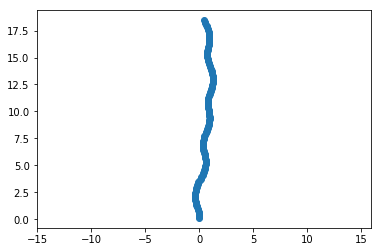

In [16]:
if __name__== "__main__":
     main()
   
    

    